In [1]:
import pandas as pd
import numpy as np
from rpca import RobustPCA
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import entropy
from optht import optht
from scipy.optimize import minimize
from sklearn import preprocessing
import itertools
from matplotlib import cm

def effective_bets(weights, singular_values_matrix, eigen_vector_matrix, vol, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(vol) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    p_norm = np.divide(p, p.sum())
    if k is not None:
        p_norm = p_norm[:k]
    eta = np.exp(-np.sum(np.multiply(p_norm, np.log(p_norm))))
    return eta


## The case fot two assets

In [2]:
raw = pd.read_pickle('etf_er.pkl')
sample = raw.iloc[:, :2].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

combinations = [np.reshape(np.array(i), (S.shape[0], 1)) for i in itertools.product([1, -1], repeat=S.shape[0])]
J = np.concatenate(combinations, axis=1)
W = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ J
W = np.divide(W, W.sum(axis=0))
W

array([[ 3.09138393, -0.32365313, -0.32365313,  3.09138393],
       [-2.09138393,  1.32365313,  1.32365313, -2.09138393]])

Unconstrained problem

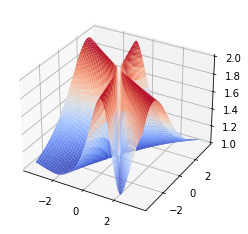

In [3]:
bounds = (-3.5, 3.5)
step_size = .01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

Positivity constrainted

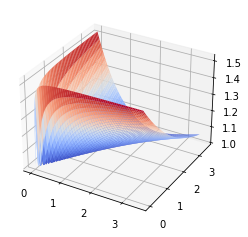

In [4]:
bounds = (0.01, 3.5)
step_size = .01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

# The case of 3 assets

In [5]:
sample = raw[['IYW', 'TLT', 'IYR']].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

combinations = [np.reshape(np.array(i), (S.shape[0], 1)) for i in itertools.product([1, -1], repeat=S.shape[0])]
J = np.concatenate(combinations, axis=1)
W = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ J
W = np.divide(W, W.sum(axis=0))
W

array([[-1.28651067,  0.33459883,  0.56461691, -0.28543089, -0.28543089,
         0.56461691,  0.33459883, -1.28651067],
       [ 1.49004811,  0.9747072 ,  0.461616  ,  0.33369417,  0.33369417,
         0.461616  ,  0.9747072 ,  1.49004811],
       [ 0.79646255, -0.30930602, -0.02623291,  0.95173672,  0.95173672,
        -0.02623291, -0.30930602,  0.79646255]])

No positivity constraint in place

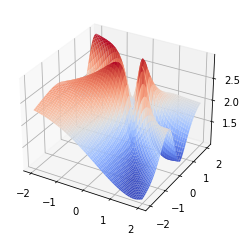

In [6]:
bounds = (-2, 2)
step_size = .01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2, 1 - w1 - w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

With positivity constraint in place

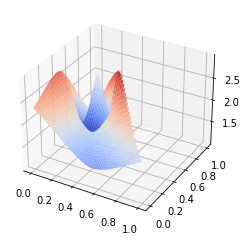

In [7]:
bounds = (0, 1)
step_size = .001
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        if w1 + w2 < 1:
            w = np.array([w1, w2, 1 - w1 - w2])
            Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)
        else:
            Z.loc[r, c] = np.nan

Z_diag = Z.fillna(method='ffill', axis=1)
X_diag = pd.DataFrame(X)
X_diag = X_diag.where(~Z.isnull())
X_diag.fillna(method='ffill', axis=1)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X_diag, Y, Z_diag, cmap=cm.coolwarm, antialiased=True, linewidth=0.1)

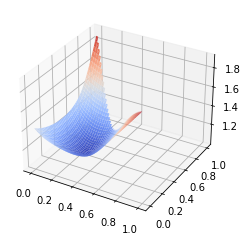

In [8]:
sample = raw[['IYW', 'IYK', 'IYC']].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

bounds = (0, 1)
step_size = .001
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        if w1 + w2 < 1:
            w = np.array([w1, w2, 1 - w1 - w2])
            Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)
        else:
            Z.loc[r, c] = np.nan

Z_diag = Z.fillna(method='ffill', axis=1)
X_diag = pd.DataFrame(X)
X_diag = X_diag.where(~Z.isnull())
X_diag.fillna(method='ffill', axis=1)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X_diag, Y, Z_diag, cmap=cm.coolwarm, antialiased=True, linewidth=0.1)

- The result above shows the corner solution nature of the problem when regularized!
- Also, the corner case solution is more present when there is more correlation in the set (like in the case of equities)
- In non so correlated cases (cross-asset class) the result tends to be more balanced (because the higher order eigenvectors tend to *positively* load on other asset classes, in this case)